In [36]:
import logging
import os
import sys
import math
import argparse
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
import scipy
from scipy import stats
import seaborn

In [2]:
def doNumber(data_EC, data_Layer, data_number, data_true):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4'),
            ('Output_number_estimated', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true

    np.delete(outdata, np.where(outdata['Output_number_true']==0))
    np.delete(outdata, np.where(outdata['Output_number'][:,0]>=0.999))

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [3]:
def plot_confusion_matrix(data, accuracy, labels, title, output_filename, layer):

    plt.style.use('seaborn')
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title(f'Confusion Matrix for {title} {layer}', fontdict = {'fontsize' : 14})
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, vmin=0, vmax=1, annot=True, cmap="Greys", cbar_kws={'label': 'Cluster Density'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    ax.text(1, 1, f'Accuracy = {accuracy:.2f}', size='12',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()

In [4]:
def doMatrix(matrix):
    matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy, matrix

def doConfusion(data, title, outpath, thrsh):

    for layer in data:
        
        data[layer]['Output_number_estimated'] = np.argmax(data[layer]['Output_number'], axis=1) + 1
        '''
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 1
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 2
        data[layer]['Output_number_estimated'][
            np.where(data[layer]['Output_number'][:,2] >= thrsh[layer][1])
        ] = 3
        '''
        matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])
        accuracy, matrix = doMatrix(matrix)
        plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}{title}_{layer}_confusion.png'.replace(" ", "_"), layer)

    matrix = confusion_matrix(np.concatenate([data[x] for x in data])['Output_number_true'], \
                np.concatenate([data[x] for x in data])['Output_number_estimated'], labels=[1,2,3])
    accuracy, matrix = doMatrix(matrix)
    plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}{title}_total_confusion.png'.replace(" ", "_"), 'All Layers')
        

In [5]:
def loadData(path):
    with h5.File(path, 'r') as data:
        data_x = data['input'][()]
        data_Layer = data_x[:,0]
        data_EC = data_x[:,1]
        data_true = data_x[:,2]
        data_2pr = data_x[:,3]
        data_3pr = data_x[:,4]
        data_1pr = 1-data_2pr-data_3pr
        data_number = np.ndarray((data_1pr.shape[0],3))
        data_number[:,0] = data_1pr
        data_number[:,1] = data_2pr
        data_number[:,2] = data_3pr
    data = doNumber(data_EC, data_Layer, data_number, data_true)
    return data

In [6]:
def doAccuracy(matrix, weighted):
    if weighted:
        matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy

def findThresh(min, max, steps, weighted):
    bestThresh = {'IBL' : [0,0], 'Barrel' : [0,0], 'Endcap' : [0,0]}
    for k, layer in enumerate(data):
        accuracy = 0
        for thrs1 in np.linspace(min, max, steps):
            for thrs2 in np.linspace(min, max, steps):
                thrs = [thrs1, thrs2]
                    
                data[layer]['Output_number_estimated'][
                    np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
                ] = 1
                data[layer]['Output_number_estimated'][
                    np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
                ] = 2
                data[layer]['Output_number_estimated'][
                    np.where(data[layer]['Output_number'][:,2] >= thrs[1])
                ] = 3

                matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])

                tempAccuracy = doAccuracy(matrix, weighted)
                
                if accuracy > tempAccuracy:
                    pass
                    # print('worse')
                    # print(f'{tempAccuracy:4f} < {accuracy:4f}')
                else:
                    # print('better')
                    # print(f'{tempAccuracy:4f} >= {accuracy:4f}')
                    bestThresh[layer] = thrs
                    accuracy = tempAccuracy

        bestThresh[layer][0] = round(bestThresh[layer][0], 2)
        bestThresh[layer][1] = round(bestThresh[layer][1], 2)
        print(f"Best Threshold for {layer}: {bestThresh[layer]}, with accuracy: {accuracy}")
    print(f"Best Threshold: {bestThresh}")
    return bestThresh

In [7]:
def _2dhist():
    for i in range(1, 4):
        isel = np.where(data['IBL']['Output_number_true'] == i)
        x = data['IBL']['Output_number'][isel][:,1]
        y = data['IBL']['Output_number'][isel][:,2]

        plt.hist2d(x, y, bins=(100,100), norm=mcolors.LogNorm())
        plt.title(f'Distribution for {i} particle clusters')
        plt.xlabel('2 Particle Confidence')
        plt.xlabel('3 Particle Confidence')
        cbar = plt.colorbar()
        cbar.set_label('')
        plt.show()
        plt.close()

In [25]:
data = loadData('data/dijet7w.h5')
bestThresh = findThresh(0.1, 1, 100, True)
outpath = "output/Cutoff/"
doConfusion(data, 'Equal Weighted Dijet7w', outpath, bestThresh)
print('Done!')

data = loadData('data/ttbar.h5')
bestThresh = findThresh(0.1, 1, 100, True)
outpath = "output/Cutoff/"
doConfusion(data, 'Equal Weighted TTbar', outpath, bestThresh)
print('Done!')


Best Threshold for IBL: [0.5, 0.39], with accuracy: 0.7653825930881043
Best Threshold for Barrel: [0.46, 0.48], with accuracy: 0.7621635892650914
Best Threshold for Endcap: [1.0, 1.0], with accuracy: nan
Best Threshold: {'IBL': [0.5, 0.39], 'Barrel': [0.46, 0.48], 'Endcap': [1.0, 1.0]}
Done!
Best Threshold for IBL: [0.59, 0.38], with accuracy: 0.7441904303143304
Best Threshold for Barrel: [0.42, 0.57], with accuracy: 0.721274743031051
Best Threshold for Endcap: [1.0, 1.0], with accuracy: nan
Best Threshold: {'IBL': [0.59, 0.38], 'Barrel': [0.42, 0.57], 'Endcap': [1.0, 1.0]}
Done!


In [28]:
data = loadData('data/dijet7w.h5')
print(np.concatenate([data[x] for x in data]).shape)
data = loadData('data/ttbar.h5')
print(np.concatenate([data[x] for x in data]).shape)

(649542,)
(362711,)


Layer: IBL
Probability when truth 1: [0.80 0.16 0.03]


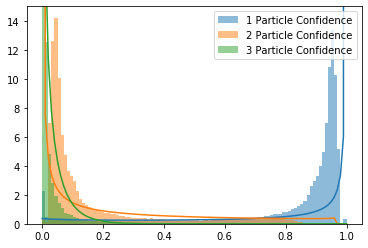


Probability when truth 2: [0.16 0.58 0.26]


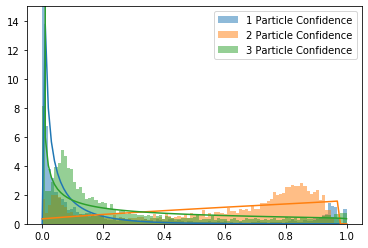


Probability when truth 3: [0.04 0.29 0.67]


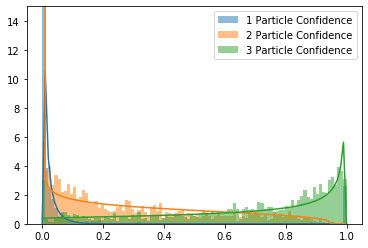



Layer: Barrel
Probability when truth 1: [0.82 0.14 0.04]


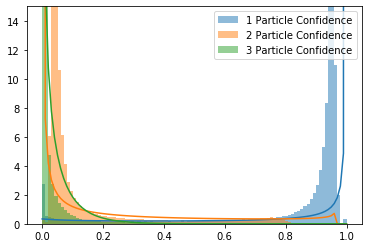


Probability when truth 2: [0.15 0.52 0.33]


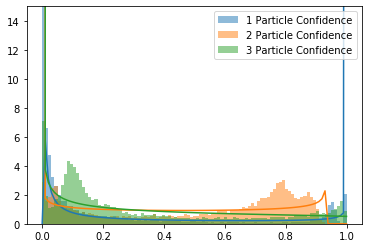


Probability when truth 3: [0.07 0.22 0.72]


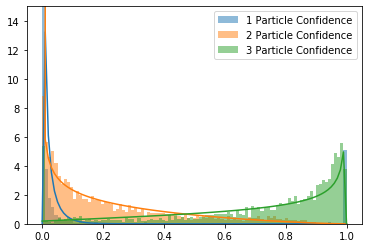



Layer: Endcap
Probability when truth 1: [0.63 0.35 0.01]


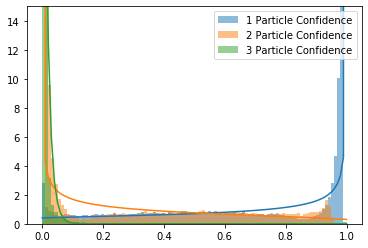


Probability when truth 2: [0.38 0.58 0.04]


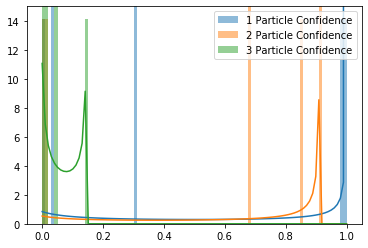

ValueError: zero-size array to reduction operation minimum which has no identity

In [43]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
data = loadData('data/dijet7w.h5')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for layer in data:
    print(f'Layer: {layer}')
    for i in range(3):
        dist = []
        mean = np.array([0.0, 0.0, 0.0])
        bins = np.linspace(0, 1, 100)

        for j in range(3):
            prob = data[layer][data[layer]['Output_number_true']==i+1]['Output_number'][:,j]
            mean[j] = np.mean(prob)
            std = np.std(prob)
            a1, b1, loc1, scale1 = stats.beta.fit(prob)
            plt.hist(prob, bins, alpha=0.5, label=f'{j+1} Particle Confidence', density=True, color=colors[j])
            pdf = stats.beta.pdf(bins, a1, b1, loc1, scale1)
            plt.plot(bins, pdf, color=colors[j])
            dist.append(prob)
        print(f'Probability when truth {i+1}: {mean}')
        plt.legend(loc='upper right')
        plt.ylim(0,15)
        plt.show()
        print('')
    print('')

In [27]:
data = loadData('data/dijet7w.h5')
bestThresh = {'IBL': [0.6, 0.2], 'Barrel': [0.6, 0.2], 'Endcap': [0.6, 0.2]}
outpath = "output/Cutoff/"
doConfusion(data, 'Max Dijet7w', outpath, bestThresh)
print('Done!')

data = loadData('data/ttbar.h5')
bestThresh = {'IBL': [0.6, 0.2], 'Barrel': [0.6, 0.2], 'Endcap': [0.6, 0.2]}
outpath = "output/Cutoff/"
doConfusion(data, 'Max ttbar', outpath, bestThresh)
print('Done!')

Done!
Done!
